# **Building a Multimodal Recommender Application for Women's Apparel**

In this project, I aim to develop a recommender application tailored specifically for women's apparel. What makes this project particularly intriguing is the fusion of numerical and textual data, making it an example of multimodal machine learning.

##  Data Loading and Preprocessing

In [48]:
import pandas as pd

# Read csv file
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [49]:
# Check shape
df.shape

(23486, 11)

In [50]:
# Drop duplicate rows
df.drop_duplicates(inplace=True)
# Drop rows with any missing values
df.dropna(inplace=True)
df.shape

(19662, 11)

This code drops the duplicate rows and rows with null values.

<Axes: >

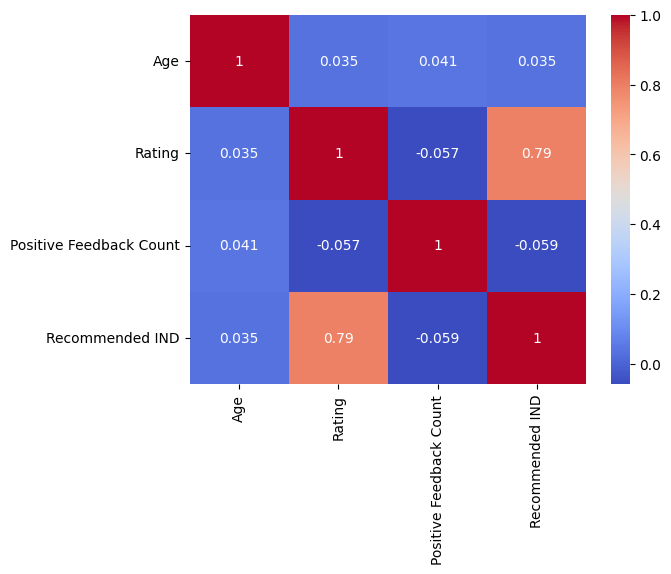

In [51]:
import seaborn as sns

# Compute correlation matrix
correlation_matrix = df[["Age", "Rating", "Positive Feedback Count", "Recommended IND"]].corr()

# Plot heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')


This heatmap allows me to form a hypothesis before moving on to the machine learning task. Based on the correlation matrix of variables, the 'Rating' variable seems to be the best factor that influences the target variable 'Recommended IND' - this is seen from the high correlation coefficient between them.

In [52]:
# Split df into features and label
features_df = df[['Age', 'Review Text', 'Rating', 'Positive Feedback Count', 'Class Name']]
label_df = df[['Recommended IND']]

features_df.head()

,Age,Review Text,Rating,Positive Feedback Count,Class Name
2,60,I had such high hopes for this dress and reall...,3,0,Dresses
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,0,Pants
4,47,This shirt is very flattering to all due to th...,5,6,Blouses
5,49,"I love tracy reese dresses, but this one is no...",2,4,Dresses
6,39,I aded this in my basket at hte last mintue to...,5,1,Knits


In [53]:
label_df.head()

,Recommended IND
2,0
3,1
4,1
5,0
6,1


In [54]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features_df, label_df, test_size=0.2, random_state=43)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15729, 5), (3933, 5), (15729, 1), (3933, 1))

In [55]:
X_train["Class Name"].value_counts()

Class Name
Dresses           4347
Knits             3153
Blouses           2064
Sweaters           957
Pants              914
Jeans              787
Fine gauge         756
Skirts             632
Jackets            466
Lounge             455
Outerwear          242
Swim               237
Shorts             209
Sleep              142
Legwear            110
Intimates           95
Layering            89
Trend               72
Chemises             1
Casual bottoms       1
Name: count, dtype: int64

In [56]:
X_test["Class Name"].value_counts()

Class Name
Dresses       1024
Knits          828
Blouses        523
Sweaters       261
Pants          243
Jeans          183
Fine gauge     171
Skirts         164
Jackets        132
Lounge         119
Swim            56
Shorts          51
Outerwear       39
Trend           35
Sleep           32
Layering        26
Intimates       25
Legwear         21
Name: count, dtype: int64

This code splits the data into appropriate train and test splits.

## Feature Engineering

In [57]:
from sklearn.preprocessing import MinMaxScaler

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training features
scaler.fit(X_train[['Age', 'Rating', 'Positive Feedback Count']])

# Transform only training features
X_train[['Age', 'Rating', 'Positive Feedback Count']] = scaler.transform(X_train[['Age', 'Rating', 'Positive Feedback Count']])

X_train.head()

,Age,Review Text,Rating,Positive Feedback Count,Class Name
17425,0.345679,If you're a girl with no junk in the trunk buy...,1.00,0.008197,Pants
20221,0.037037,"The shirt is great, aside from the fact that i...",0.75,0.000000,Knits
10980,0.234568,When i saw this dress online - it was a must h...,1.00,0.049180,Dresses
15750,0.419753,I love this sweater. hoping to order the other...,1.00,0.000000,Fine gauge
15444,0.320988,This dress fits perfectly and true to size. th...,1.00,0.000000,Dresses


This code uses the MinMaxScaler to scale the numeric features Age, Rating and Positive Feedback Count.

In [58]:
from sklearn.preprocessing import OneHotEncoder

# Transform categorical nominal features into 1-hot encodings
class_list = X_train["Class Name"].to_list()

# Convert to list of lists - scikit 1-hot encoder expects
class_list_of_list = [[el] for el in class_list]

# Create one-hot encoders
class_encoder = OneHotEncoder()

# Fit the data
class_transformed = class_encoder.fit_transform(class_list_of_list)

# Create numpy matrices
class_transformed = class_transformed.toarray()

# Merging the 1-hot vectors back to the dataframe
class_transformed_df = pd.DataFrame(class_transformed)

print(f"class variable 1-hot shape = {class_transformed_df.shape}")

class variable 1-hot shape = (15729, 20)


In [59]:
# Concatenate back into the dataframe
X_train = pd.concat([X_train.reset_index(drop=True), class_transformed_df], axis=1)
print(f"Shape of data after concatenating all 1-hot encodings = {X_train.shape}")

# Now drop columns we have already transformed into 1-hot
X_train = X_train.drop(columns=["Class Name"], axis=1)
# Now, let's print the shape of our f inal data
print(f"Shape of data after droping original categorical columns = {X_train.shape}")

Shape of data after concatenating all 1-hot encodings = (15729, 25)
Shape of data after droping original categorical columns = (15729, 24)


The above code snippets convert the categorical "Class Name" variable to one-hot vectors using OneHotEncoder.

In [60]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [61]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

stop_words = list(stopwords.words('english'))

# Create CountVectorizer to convert text into count vectors. Restrict the vocabulary size to 1000.
vectorizer = CountVectorizer(max_features = 5000, stop_words=stop_words)
review_text_ngrams  = vectorizer.fit_transform(X_train['Review Text'])

# Convert to a dense matrix
review_text_ngrams = review_text_ngrams.toarray()

# Create a DataFrame from the N-hot vectors
review_text_ngrams_df = pd.DataFrame(review_text_ngrams, columns=vectorizer.get_feature_names_out())

# Concatenate the N-hot vectors with the original DataFrame
X_train = pd.concat([X_train, review_text_ngrams_df], axis=1)

# Drop the original "Review Text" column
X_train = X_train.drop("Review Text", axis=1)

X_train.head()

,Age,Rating,Positive Feedback Count,0,1,2,3,4,5,6,...,zero,zip,zipped,zipper,zippered,zippers,zipping,zips,zone,zoom
0,0.345679,1.00,0.008197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.037037,0.75,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.234568,1.00,0.049180,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.419753,1.00,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.320988,1.00,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


This code converts Review Text to N-hot vectors using CountVectorizer.

In [62]:
num_features = len(vectorizer.get_feature_names_out())
print(f"Max features used in CountVectorizer: {num_features}")

Max features used in CountVectorizer: 5000


This code shows the max_features variable set in CountVectorizer. A larger value gives better results but uses more computational resources. I decide to use a max_features value of 5000 to get a good balance between valid output and computational power.

## Neural Network Model Building

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.losses import BinaryCrossentropy

# Convert X_train and y_train to NumPy arrays
X_train = X_train.values
y_train = y_train.values

# Get the feature_size from the input data
feature_size = X_train.shape[1]

# Define the model architecture
model = Sequential()

# Input Layer
model.add(Input(shape=(feature_size,)))
model.add(Dense(128, activation='relu'))

# Hidden Layer 1
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Hidden Layer 2
model.add(Dense(32, activation='relu'))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# visualize the model design
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               643072    
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 653441 (2.49 MB)
Trainable params: 653441 (2.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


This code constructs a neural network as follows:

1. Input Layer: Consists of 128 neurons.
2. Hidden Layer 1: Consists of 64 neurons. Uses ReLU activation. Uses a Dropout layer with dropout probability set to 0.2.
3. Hidden Layer 2: Consists of 32 neurons. Uses ReLU activation
4. Output Layer: Consists of 1 neuron with Sigmoid activation.

In [64]:
# Compile the model
model.compile(optimizer=SGD(learning_rate=0.01),
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

This code compiles the model using the `BinaryCrossentropy` loss function, the SGD optimizer with learning rate 0.01, and the accuracy evaluation metric.

In [65]:
# Train the model on the training data
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
492/492 [==============================] - 2s 3ms/step - loss: 0.5002 - accuracy: 0.8122
Epoch 2/50
492/492 [==============================] - 2s 4ms/step - loss: 0.3858 - accuracy: 0.8168
Epoch 3/50
492/492 [==============================] - 2s 4ms/step - loss: 0.2830 - accuracy: 0.8287
Epoch 4/50
492/492 [==============================] - 2s 5ms/step - loss: 0.2168 - accuracy: 0.9140
Epoch 5/50
492/492 [==============================] - 2s 4ms/step - loss: 0.1727 - accuracy: 0.9331
Epoch 6/50
492/492 [==============================] - 2s 4ms/step - loss: 0.1492 - accuracy: 0.9429
Epoch 7/50
492/492 [==============================] - 2s 4ms/step - loss: 0.1331 - accuracy: 0.9479
Epoch 8/50
492/492 [==============================] - 2s 4ms/step - loss: 0.1246 - accuracy: 0.9518
Epoch 9/50
492/492 [==============================] - 2s 4ms/step - loss: 0.1143 - accuracy: 0.9564
Epoch 10/50
492/492 [==============================] - 2s 5ms/step - loss: 0.1094 - accuracy: 0.9606

The output above shows that the neural network has achieved nearly perfect accuracy of 99.97% on the training data after 50 epochs and a batch size of 32.

## Model Evaluation on Test Data

Here I apply the same preprocessing steps applied to X_train on the unseen test data X_test.

In [66]:
# Transform X_test features
X_test[['Age', 'Rating', 'Positive Feedback Count']] = scaler.transform(X_test[['Age', 'Rating', 'Positive Feedback Count']])
X_test.head()

,Age,Review Text,Rating,Positive Feedback Count,Class Name
1203,0.246914,These jeans have been the best pair of jeans i...,1.00,0.000000,Jeans
5851,0.197531,I adore these jeans! i bought them in a size 3...,1.00,0.000000,Jeans
11858,0.395062,I purchased the blue one - it's a very brillia...,0.75,0.008197,Knits
7364,0.580247,Love the rifle print on this dress. the fit is...,0.75,0.008197,Dresses
7906,0.222222,"Great cut, super flattering! it does run a lit...",1.00,0.262295,Knits


This code applies similar scaling of Numeric features (as applied to X_train) to X_test.

In [67]:
# Check shape before one-hot encoding
X_test.shape

(3933, 5)

In [68]:
# One-hot encode "Class Name" variable in X_test
class_list_test = X_test["Class Name"].to_list()
class_list_of_list_test = [[el] for el in class_list_test]
class_transformed_test = class_encoder.transform(class_list_of_list_test)
class_transformed_df_test = pd.DataFrame(class_transformed_test.toarray())

# Concatenate the one-hot encoded columns back to the X_test DataFrame
X_test = pd.concat([X_test.reset_index(drop=True), class_transformed_df_test], axis=1)

# Drop the original "Class Name" column from X_test
X_test = X_test.drop(columns=["Class Name"], axis=1)
X_test.head()

,Age,Review Text,Rating,Positive Feedback Count,0,1,2,3,4,5,...,10,11,12,13,14,15,16,17,18,19
0,0.246914,These jeans have been the best pair of jeans i...,1.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.197531,I adore these jeans! i bought them in a size 3...,1.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.395062,I purchased the blue one - it's a very brillia...,0.75,0.008197,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.580247,Love the rifle print on this dress. the fit is...,0.75,0.008197,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.222222,"Great cut, super flattering! it does run a lit...",1.00,0.262295,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
# Check shape after one-hot encoding
X_test.shape

(3933, 24)

The number of rows remains constant which means one-hot encoding was applied correctly to the "Class Name" column in X_test.

In [70]:
# Convert the "Review Text" column in X_test to N-hot vectors
review_text_ngrams_test = vectorizer.transform(X_test['Review Text']).toarray()

# Create a DataFrame from the N-hot vectors
review_text_ngrams_df_test = pd.DataFrame(review_text_ngrams_test, columns=vectorizer.get_feature_names_out())

# Concatenate the N-hot vectors with the original X_test DataFrame
X_test = pd.concat([X_test, review_text_ngrams_df_test], axis=1)

# Drop the original "Review Text" column from X_test
X_test = X_test.drop("Review Text", axis=1)
X_test.head()

,Age,Rating,Positive Feedback Count,0,1,2,3,4,5,6,...,zero,zip,zipped,zipper,zippered,zippers,zipping,zips,zone,zoom
0,0.246914,1.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.197531,1.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.395062,0.75,0.008197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.580247,0.75,0.008197,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.222222,1.00,0.262295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


This code uses the same vectorizer fitted on the training data to transform the test data ("Review Text") column.

In [71]:
X_test1 = X_test.to_numpy()
y_test1 = y_test.to_numpy()

# evaluate the model on test data
_, test_accuracy = model.evaluate(X_test1, y_test1)
print('Accuracy on unseen Test Data: %.2f' % (test_accuracy*100))

123/123 [==============================] - 0s 2ms/step - loss: 0.3188 - accuracy: 0.9324
Accuracy on unseen Test Data: 93.24


After evaluating the model's performance on the test split, the model achieves an accuracy of 93.24.

**Accuracy on train data: 99.97**

**Accuracy on test data:  93.24**

While the model performs exceptionally well on the training data, its performance on unseen test data is still quite good, indicating successful learning and generalization. However, given the significant difference between the training and test accuracies, there's a possibility that the model is overfitting to the training data. Regularization techniques or adjusting model complexity could be considered to mitigate this overfitting.

## Ablation Study

Query: Investigate how dropping the variable "Review Text" affects the test accuracy of the neural network.

In [72]:
X_train_ablation, X_test_ablation, y_train_ablation, y_test_ablation = train_test_split(features_df, label_df, test_size=0.2, random_state=43)
X_train_ablation.shape, X_test_ablation.shape, y_train_ablation.shape, y_test_ablation.shape

((15729, 5), (3933, 5), (15729, 1), (3933, 1))

In this code I split the original dataframe once again into "ablation" train-test splits using the same random_state value of 43 to achieve the same splits as before.

In [73]:
# Drop the Review Text column from train and test splits
X_train_ablation = X_train_ablation.drop('Review Text', axis=1)
X_test_ablation = X_test_ablation.drop('Review Text', axis=1)

X_train_ablation.head()

,Age,Rating,Positive Feedback Count,Class Name
17425,46,5,1,Pants
20221,21,4,0,Knits
10980,37,5,6,Dresses
15750,52,5,0,Fine gauge
15444,44,5,0,Dresses


In [74]:
# Perform Feature scaling using the same scaler on train and test splits
X_train_ablation[['Age', 'Rating', 'Positive Feedback Count']] = scaler.transform(X_train_ablation[['Age', 'Rating', 'Positive Feedback Count']])
X_test_ablation[['Age', 'Rating', 'Positive Feedback Count']] = scaler.transform(X_test_ablation[['Age', 'Rating', 'Positive Feedback Count']])

X_train_ablation.head()

,Age,Rating,Positive Feedback Count,Class Name
17425,0.345679,1.00,0.008197,Pants
20221,0.037037,0.75,0.000000,Knits
10980,0.234568,1.00,0.049180,Dresses
15750,0.419753,1.00,0.000000,Fine gauge
15444,0.320988,1.00,0.000000,Dresses


In [75]:
print("Shape before one-hot encoding: ", X_train_ablation.shape)

# One-hot encode "Class Name" variable in X_train_ablation
class_list_train_ablation = X_train_ablation["Class Name"].to_list()
class_list_of_list_train_ablation = [[el] for el in class_list_train_ablation]
class_transformed_train_ablation = class_encoder.transform(class_list_of_list_train_ablation)
class_transformed_df_train_ablation = pd.DataFrame(class_transformed_train_ablation.toarray())

# Concatenate the one-hot encoded columns back to the X_train_ablation DataFrame
X_train_ablation = pd.concat([X_train_ablation.reset_index(drop=True), class_transformed_df_train_ablation], axis=1)

# Drop the original "Class Name" column from X_train_ablation
X_train_ablation = X_train_ablation.drop(columns=["Class Name"], axis=1)
print("Shape after one-hot encoding: ", X_train_ablation.shape)
X_train_ablation.head()

Shape before one-hot encoding:  (15729, 4)
Shape after one-hot encoding:  (15729, 23)


,Age,Rating,Positive Feedback Count,0,1,2,3,4,5,6,...,10,11,12,13,14,15,16,17,18,19
0,0.345679,1.00,0.008197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.037037,0.75,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.234568,1.00,0.049180,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.419753,1.00,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.320988,1.00,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
print("Shape before one-hot encoding: ", X_test_ablation.shape)

# One-hot encode "Class Name" variable in X_test_ablation
class_list_test_ablation = X_test_ablation["Class Name"].to_list()
class_list_of_list_test_ablation = [[el] for el in class_list_test_ablation]
class_transformed_test_ablation = class_encoder.transform(class_list_of_list_test_ablation)
class_transformed_df_test_ablation = pd.DataFrame(class_transformed_test_ablation.toarray())

# Concatenate the one-hot encoded columns back to the X_test_ablation DataFrame
X_test_ablation = pd.concat([X_test_ablation.reset_index(drop=True), class_transformed_df_test_ablation], axis=1)

# Drop the original "Class Name" column from X_test_ablation
X_test_ablation = X_test_ablation.drop(columns=["Class Name"], axis=1)
print("Shape after one-hot encoding: ", X_test_ablation.shape)
X_test_ablation.head()

Shape before one-hot encoding:  (3933, 4)
Shape after one-hot encoding:  (3933, 23)


,Age,Rating,Positive Feedback Count,0,1,2,3,4,5,6,...,10,11,12,13,14,15,16,17,18,19
0,0.246914,1.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.197531,1.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.395062,0.75,0.008197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.580247,0.75,0.008197,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.222222,1.00,0.262295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
# Convert train and set sets to NumPy arrays
X_train = X_train_ablation.values
y_train = y_train_ablation.values

# Get the feature_size from the input data
feature_size = X_train.shape[1]

# Define the model_ablation architecture
model_ablation = Sequential()

# Input Layer
model_ablation.add(Input(shape=(feature_size,)))
model_ablation.add(Dense(128, activation='relu'))

# Hidden Layer 1
model_ablation.add(Dense(64, activation='relu'))
model_ablation.add(Dropout(0.2))

# Hidden Layer 2
model_ablation.add(Dense(32, activation='relu'))

# Output Layer
model_ablation.add(Dense(1, activation='sigmoid'))

# visualize the model_ablation design
model_ablation.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               3072      
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 13441 (52.50 KB)
Trainable params: 13441 (52.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [78]:
# Compile model_ablation
model_ablation.compile(optimizer=SGD(learning_rate=0.01),
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

In [79]:
# Train the model on the training data
model_ablation.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
492/492 [==============================] - 2s 3ms/step - loss: 0.4876 - accuracy: 0.8072
Epoch 2/50
492/492 [==============================] - 2s 3ms/step - loss: 0.3582 - accuracy: 0.8230
Epoch 3/50
492/492 [==============================] - 2s 5ms/step - loss: 0.2383 - accuracy: 0.8982
Epoch 4/50
492/492 [==============================] - 2s 3ms/step - loss: 0.1787 - accuracy: 0.9201
Epoch 5/50
492/492 [==============================] - 2s 3ms/step - loss: 0.1617 - accuracy: 0.9273
Epoch 6/50
492/492 [==============================] - 2s 3ms/step - loss: 0.1558 - accuracy: 0.9269
Epoch 7/50
492/492 [==============================] - 2s 4ms/step - loss: 0.1540 - accuracy: 0.9294
Epoch 8/50
492/492 [==============================] - 2s 5ms/step - loss: 0.1534 - accuracy: 0.9287
Epoch 9/50
492/492 [==============================] - 4s 8ms/step - loss: 0.1535 - accuracy: 0.9290
Epoch 10/50
492/492 [==============================] - 3s 6ms/step - loss: 0.1507 - accuracy: 0.9300

In [80]:
X_test_ablation = X_test_ablation.to_numpy()
y_test_ablation = y_test_ablation.to_numpy()

# evaluate the model_ablation on test data
a, test_ablation_accuracy = model_ablation.evaluate(X_test_ablation, y_test_ablation)
print('Accuracy on unseen Test Data: %.2f' % (test_ablation_accuracy*100))

123/123 [==============================] - 1s 4ms/step - loss: 0.1345 - accuracy: 0.9402
Accuracy on unseen Test Data: 94.02


**Results of Ablation Test**

Based on the ablation study above (after retraining the model on the train and test splits without the "Review Text" column), the accuracy of the neural network on the unseen test data remains about the same at 94%. Although the training accuracy is lower in the ablation test (93.3% < 99.9%), the accuracy on the unseen test sets remain the same which means the "Review Text" column doesn't influence the model's accuracy.

## Thoughts

I think that Multimodal machine learning is significant in addressing real-world challenges involving heterogeneous data types since It allows models to leverage data from varioues sources, leading to a more comprehensive and robust representation. I believe that this is particularly valuable in complex domains where a single data modality may be insufficient to capture the full complexity of the problem.